In [2]:
import torch 
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
df = pd.read_csv('../Datasets\TimeSeriesData\Alcohol_Sales.csv', index_col=0, parse_dates=True)

In [6]:
torch.cuda.current_device()

0

In [4]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [5]:
df.tail()

,S4248SM144NCEN
DATE,
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174
2018-12-01,15504
2019-01-01,10718


In [6]:
df = df.dropna()

<AxesSubplot:xlabel='DATE'>

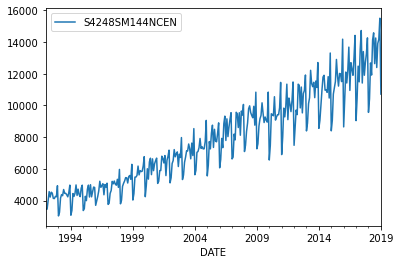

In [7]:
df.plot()

In [8]:
y = df['S4248SM144NCEN'].values.astype(float)
len(y)

325

In [9]:
test_size = 12

In [10]:
train_set = y[:-12]
test_set = y[-12:]

In [12]:
len(train_set)

313

In [13]:
len(test_set)

12

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler(feature_range=(-1, 1))

In [16]:
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [18]:
train_norm[:5]

array([[-0.92683135],
       [-0.92700231],
       [-0.83400291],
       [-0.73792632],
       [-0.79656381]])

In [19]:
train_norm = torch.FloatTensor(train_norm).view(-1)

In [21]:
train_norm[:5]

tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966])

In [22]:
wd_sz = 12

In [34]:
def input_data(seq, ws):
    out = []

    for i in range(len(seq) - ws):
        window = seq[i:i + ws]
        label = seq[i + ws:i + ws + 1]
        out.append((window, label))
    
    return out

In [35]:
train_data = input_data(train_norm, wd_sz)

In [36]:
len(train_data)

301

In [37]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

In [38]:
model = LSTMnetwork()
model

LSTMnetwork(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [31]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [32]:
for param in model.parameters():
    print(param.numel())

400
40000
400
400
100
1


In [39]:
epochs = 100

import time
start_time = time.time()

for epoch in range(epochs):
    
    # extract the sequence & label from the training data
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.03211827
Epoch:  2 Loss: 0.03211827
Epoch:  3 Loss: 0.03211827
Epoch:  4 Loss: 0.03211827
Epoch:  5 Loss: 0.03211827
Epoch:  6 Loss: 0.03211827
Epoch:  7 Loss: 0.03211827
Epoch:  8 Loss: 0.03211827
Epoch:  9 Loss: 0.03211827
Epoch: 10 Loss: 0.03211827
Epoch: 11 Loss: 0.03211827
Epoch: 12 Loss: 0.03211827
Epoch: 13 Loss: 0.03211827
Epoch: 14 Loss: 0.03211827
Epoch: 15 Loss: 0.03211827
Epoch: 16 Loss: 0.03211827
Epoch: 17 Loss: 0.03211827
Epoch: 18 Loss: 0.03211827
Epoch: 19 Loss: 0.03211827
Epoch: 20 Loss: 0.03211827
Epoch: 21 Loss: 0.03211827
Epoch: 22 Loss: 0.03211827
Epoch: 23 Loss: 0.03211827
Epoch: 24 Loss: 0.03211827
Epoch: 25 Loss: 0.03211827
Epoch: 26 Loss: 0.03211827
Epoch: 27 Loss: 0.03211827
Epoch: 28 Loss: 0.03211827
Epoch: 29 Loss: 0.03211827
Epoch: 30 Loss: 0.03211827
Epoch: 31 Loss: 0.03211827
Epoch: 32 Loss: 0.03211827
Epoch: 33 Loss: 0.03211827
Epoch: 34 Loss: 0.03211827
Epoch: 35 Loss: 0.03211827
Epoch: 36 Loss: 0.03211827
Epoch: 37 Loss: 0.03211827
E

In [52]:
future = 12

# Add the last window of training values to the list of predictions
preds = train_norm[-wd_sz:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-wd_sz:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())

In [56]:
preds[wd_sz:]

[-0.06874656677246094,
 -0.07428183406591415,
 -0.07734911143779755,
 -0.0790170282125473,
 -0.07993566989898682,
 -0.08044394850730896,
 -0.08071907609701157,
 -0.08087684214115143,
 -0.08096402138471603,
 -0.08101631700992584,
 -0.08104851841926575,
 -0.08106987178325653]

In [66]:
true_predictions = scaler.inverse_transform(np.array(preds[wd_sz:]).reshape(-1, 1))

In [67]:
true_predictions

array([[8478.36695766],
       [8445.98841163],
       [8428.04637264],
       [8418.28989347],
       [8412.91629893],
       [8409.94312321],
       [8408.33376437],
       [8407.4109119 ],
       [8406.90095691],
       [8406.59505365],
       [8406.40669151],
       [8406.281785  ]])

In [68]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64